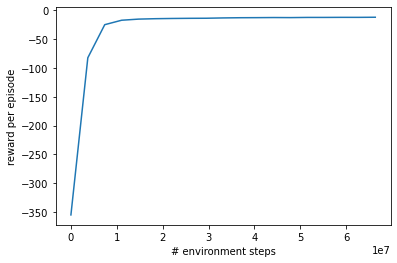

In [ ]:
from absl.testing import absltest
from absl.testing import parameterized
from brax import envs
from brax.training import ppo
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pickle

episode_length = 500
action_repeat = 1
env_name = "reacher"
save_dir = "save_1_ppo"


for i in range(8):
    xdata = []
    ydata = []

    def progress(num_steps, metrics):
      xdata.append(num_steps)
      ydata.append(metrics['eval/episode_reward'])
      clear_output(wait=True)
      plt.xlabel('# environment steps')
      plt.ylabel('reward per episode')
      plt.plot(xdata, ydata)
      plt.show()

    inference_fn, params, metrics = ppo.train(
        environment_fn=envs.create_fn(env_name, auto_reset=True),
        num_timesteps = 80_000_000, log_frequency = 20,
        reward_scaling = 1, episode_length = episode_length, normalize_observations = True,
        action_repeat = action_repeat, unroll_length = 50, num_minibatches = 32,
        num_update_epochs = 8, discounting = 0.99, learning_rate = 3e-4,
        entropy_cost = 1e-3, num_envs = 512, batch_size = 256, seed = i,
        progress_fn = progress
    )
    pickle.dump(params, open(f"{save_dir}/{env_name}_params{i}.pkl", 'wb'))
    pickle.dump(metrics, open(f"{save_dir}/{env_name}_metrics{i}.pkl", 'wb'))
    pickle.dump(ydata, open(f"{save_dir}/{env_name}_rewards.pkl{i}", 'wb'))

In [4]:
import jax
import jax.numpy as jnp
env = envs.create_fn(env_name, auto_reset=True)()
key = jax.random.PRNGKey(0)
reset_key, inference_key = jax.random.split(key)
state = env.reset(reset_key)
obs = state.obs 

In [5]:
import brax.jumpy as jp
import matplotlib.pyplot as plt


@jax.jit
def do_rnn_rollout(policy_params, key):
    init_state = env.reset(key)

    def do_one_step(carry, step_idx):
        state, policy_params, key = carry
        act_key, key = jax.random.split(key)
        actions = inference_fn(params, state.obs, act_key)
        #actions = -jnp.ones_like(actions)
        nstate = env.step(state, actions)    
        return (nstate, policy_params, key), (nstate.reward,state.obs, actions, nstate)


    _, (rewards, obs, acts, states) = jp.scan(
        do_one_step, (init_state, policy_params, key),
        (jnp.array(range(episode_length // action_repeat))),
        length=episode_length // action_repeat)

    return rewards, obs, acts, states

-15.86904
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

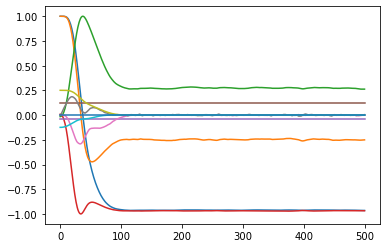

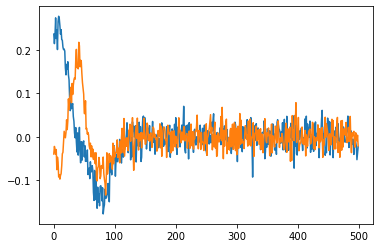

In [6]:
key, reset_key = jax.random.split(key)
(rewards, obs, acts, states) = do_rnn_rollout(params, reset_key)

done_idx = jnp.where(states.done, size=1)[0].item()
if done_idx == 0:
    done_idx = rewards.shape[0]
rewards_sum = jnp.sum(rewards[:done_idx])

plt.plot(obs);
plt.figure()
plt.plot(acts);
print(rewards_sum)
print(states.done)

In [5]:
from IPython.display import HTML
from brax.io import html



def visualize(sys, qps, height=480):
  """Renders a 3D visualization of the environment."""
  return HTML(html.render(sys, 
                          qps, height=height))

qp_flat, qp_def = jax.tree_flatten(states.qp)

qp_list = []

for i in range(qp_flat[0].shape[0]):
    qpc=[]
    for thing in qp_flat:
        qpc.append(thing[i,:])
    qp_list.append(jax.tree_unflatten(qp_def, qpc))
    

visualize(env.sys, qp_list, height=800)